In [1]:
import os.path as path

import pandas as pd
import numpy as np
from umap import UMAP

import matplotlib.pyplot as plt

In [2]:
data_train = [
    pd.read_csv(path.join(path.dirname("~/rvqe/notebooks/data/"), f"mnist.train.{d}.csv.gz"), header=None)
    for d in range(0, 10)
]

In [3]:
data_validate = [
    pd.read_csv(path.join(path.dirname("~/rvqe/notebooks/data/"), f"mnist.validate.{d}.csv.gz"), header=None)
    for d in range(0, 10)
]

In [4]:
data_test = [
    pd.read_csv(path.join(path.dirname("~/rvqe/notebooks/data/"), f"mnist.test.{d}.csv.gz"), header=None)
    for d in range(0, 10)
]

In [5]:
data_test[0].to_numpy()[0].shape

(784,)

In [6]:
def embedding(dim: int, random_state: int):
    umap = UMAP(
        n_neighbors=40,
        n_components=dim,
        min_dist=0,
        random_state=random_state,
        verbose=True,
        n_epochs=500
    )
    
    return umap.fit(
        pd.concat(data_train, ignore_index=True).to_numpy(),
        y=np.concatenate([ d*np.ones(len(data_train[d]), dtype=int) for d in range(0, 10) ])
    )

In [8]:
embeddings = {
    d: [ embedding(d, random_state=rs) for rs in [42, 43] ]
    for d in [2]
}

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0, n_components=2, n_epochs=500, n_neighbors=40,
     negative_sample_rate=5, output_metric='euclidean', output_metric_kwds=None,
     random_state=42, repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed Jul  8 16:48:55 2020 Finding Nearest Neighbors
Wed Jul  8 16:48:55 2020 Building RP forest with 17 trees
Wed Jul  8 16:48:57 2020 NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
Wed Jul  8 16:49:11 2020 Finished Nearest Neighbor Search
Wed Jul  8 16:49:12 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 e

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [62]:
class Net(nn.Module):
    def __init__(self, embedding: UMAP):
        super().__init__()
        
        self.embedding = embedding
        embedding.verbose = False
        self.in_width = embedding.n_components
        
        self.net = nn.Sequential(
            nn.Linear(self.in_width, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.embedding.transform(x)
        return self.net(torch.tensor(x))

In [63]:
Net(embeddings[2][0])

Net(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): Softmax(dim=1)
  )
)

In [18]:
train_all, validate_all, test_all = [
    pd.concat(dd, ignore_index=True).to_numpy()
    for dd in [data_train, data_validate, data_test]
]

In [65]:
train_label_all, validate_label_all, test_label_all = [
    np.concatenate([ np.ones(len(dd[i]), dtype=int)*i for i in range(len(dd)) ])   
    for dd in [data_train, data_validate, data_test]
]

In [66]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [67]:
unison_shuffled_copies(train_all, train_label_all)

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 array([1, 7, 2, ..., 2, 4, 8]))

In [68]:
train_all.take(np.arange(10)+100000, axis=0, mode="wrap")

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [78]:
def train_net_with_embedding(embedding: UMAP, batch_size: int = 3, steps: int = 1) -> Net:
    net = Net(embedding)
    net.train()
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    inputs, targets = unison_shuffled_copies(train_all, train_label_all)
    
    
    
    
    for step in range(steps):
        # get batch
        idcs = np.arange(batch_size) + step*batch_size
        ibatch = inputs.take(idcs, axis=0, mode="wrap")
        tbatch = targets.take(idcs, axis=0, mode="wrap")
        
        # optimization step
        optimizer.zero_grad()
        obatch = net(ibatch)
        loss = criterion(obatch, torch.tensor(tbatch))
        loss.backward()
        optimizer.step()
   
        if step % 10 == 0:
            print(f"{step:04d} loss={loss:3.3e}")

train_net_with_embedding(embeddings[2][0], steps=100, batch_size=100)

0000 loss=2.305e+00
0010 loss=1.958e+00
0020 loss=1.774e+00
0030 loss=1.779e+00
0040 loss=1.706e+00
0050 loss=1.669e+00
0060 loss=1.593e+00
0070 loss=1.571e+00
0080 loss=1.586e+00
0090 loss=1.611e+00


In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))
for d in range(10):
    plt.scatter(*zip(*(
            embeddings[2].transform(data_train[d].to_numpy())
        )),
        color=['#1f77b4',
               '#ff7f0e',
               '#2ca02c',
               '#d62728',
               '#9467bd',
               '#8c564b',
               '#e377c2',
               '#7f7f7f',
               '#bcbd22',
               '#17becf'][d],
        s=2,
        alpha=.4
       )
plt.show()

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30

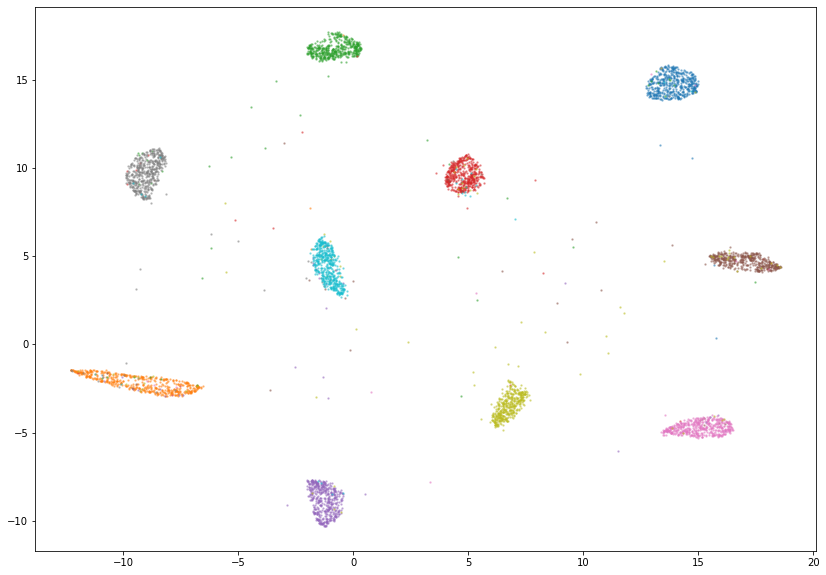

In [10]:
fig, ax = plt.subplots(1, figsize=(14, 10))
for d in range(10):
    plt.scatter(*zip(*(
            embeddings[2].transform(data_validate[d].to_numpy())
        )),
        color=['#1f77b4',
               '#ff7f0e',
               '#2ca02c',
               '#d62728',
               '#9467bd',
               '#8c564b',
               '#e377c2',
               '#7f7f7f',
               '#bcbd22',
               '#17becf'][d],
        s=2,
        alpha=.4
       )
plt.show()

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30

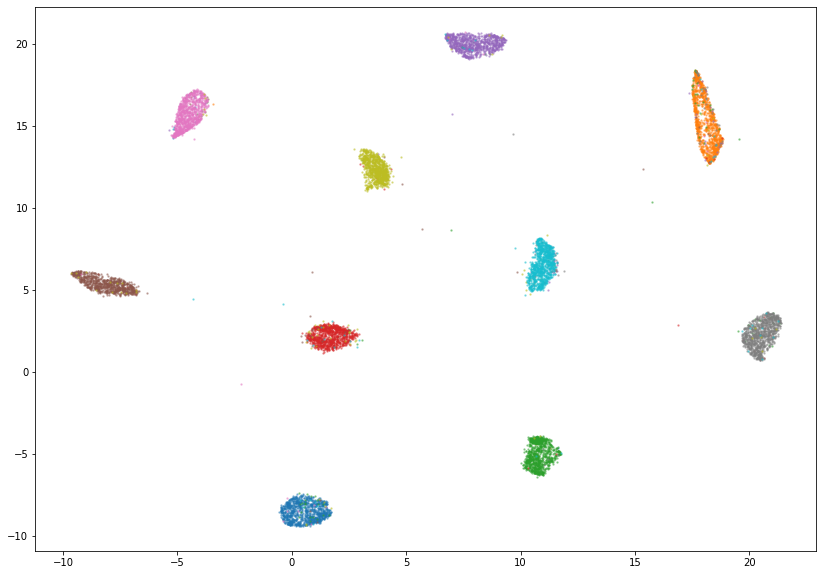

In [16]:
fig, ax = plt.subplots(1, figsize=(14, 10))
for d in range(10):
    plt.scatter(*zip(*(
            embeddings[2].transform(data_test[d].to_numpy())
        )),
        color=['#1f77b4',
               '#ff7f0e',
               '#2ca02c',
               '#d62728',
               '#9467bd',
               '#8c564b',
               '#e377c2',
               '#7f7f7f',
               '#bcbd22',
               '#17becf'][d],
        s=2,
        alpha=.4
       )
plt.show()

In [14]:
for table_list, tag in [
    (data_train, "train"),
    (data_validate, "validate"),
    (data_test, "test")
]:
    for d, table in enumerate(table_list):
        for dim in embeddings:
            embedding = embeddings[dim]
            embedded_table = pd.DataFrame(
                embedding.transform(table.to_numpy())
            )
            embedded_table.to_csv(
                path.join(path.dirname("~/rvqe/notebooks/data/"), f"mnist.{tag}.{d}.umap-{dim}.csv"),
                header=None,
                index=None
            )
        

	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	

	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	

	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	

	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	completed  96  /  166 epochs
	completed  112  /  166 epochs
	completed  128  /  166 epochs
	completed  144  /  166 epochs
	completed  160  /  166 epochs
	completed  0  /  166 epochs
	completed  16  /  166 epochs
	completed  32  /  166 epochs
	completed  48  /  166 epochs
	completed  64  /  166 epochs
	completed  80  /  166 epochs
	